# GPU 확인

In [21]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10258401101932274134
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7088302158828610847
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


# 구글 드라이브 임포트

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 학습코드

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from tqdm import tqdm
from tqdm import trange

In [24]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, MaxPooling2D
from tensorflow.keras.layers import Dense, Conv2D

from sklearn.model_selection import train_test_split

In [25]:
BASE_DIR = "/content/drive/MyDrive"

In [26]:
labelTable = ["cap_and_hat", "outerwear", "tops", "bottoms", "shoes"]

In [27]:
xDatas = np.load(f'{BASE_DIR}/xDatas32_outlier.npy')
yDatas = np.load(f'{BASE_DIR}/yDatas_outlier.npy')

In [28]:
print(len(xDatas))
print(len(yDatas))

29687
29687


In [29]:
xTrain, xValidation, yTrain, yValidation = train_test_split(xDatas, yDatas, test_size=0.2, stratify=yDatas, random_state=20)

In [30]:
imRows = 32
imCols = 32

inputShape = (imRows, imCols, 1)

In [31]:
# with tf.device("CPU:0"):
xTrain = tf.convert_to_tensor(xTrain, dtype=tf.float32)
xValidation = tf.convert_to_tensor(xValidation, dtype=tf.float32)
yTrain = tf.one_hot(yTrain, depth=len(np.unique(yTrain)))
yValidation = tf.one_hot(yValidation, depth=len(np.unique(yValidation)))

In [32]:
num_classes = 5   #10개 클래스 기억
model = Sequential()   #순차적으로 레이어를 더해주는 명령

#첫번째 컨볼루션 레이어
#입력 레이어
#컨볼루션 레이어의 컨볼루션 연산과 폴링 연산 설정
model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding="valid",
                 input_shape=inputShape))   #서로 다른 64개의 필터를 3x3사이즈로 설정하여 연산함. 이때, 최적화함수는 relu(음수는 0으로 반환), 패딩은 사이즈를 작게 두는 valid 옵션 사용
model.add(MaxPooling2D(2))   #폴링필터를 2x2로 설정하여 연산함. MaxPooling2D(2,2)와 같음
model.add(Dropout(0.3))   #30%의 노드를 삭제함

#두번째 컨볼루션 레이어
model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='valid'))
model.add(MaxPooling2D(2))
model.add(Dropout(0.3))

#세번째 컨볼루션 레이어 
model.add(Conv2D(128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(Dropout(0.3))

#첫번째 완전 연결(Fully Connected) 레이어
model.add(Flatten())   #다차원을 1차원으로 변경해주는 명령

#두번째 완전 연결(Fully Connected) 레이어, 
model.add(Dense(128, kernel_initializer='he_normal', activation='relu'))   #노드의 갯수가 256개인 히든레이어

#세번째 완전 연결(Fully Connected) 레이어, 
model.add(Dense(256, kernel_initializer='he_normal', activation='relu'))

#네번째 완전 연결(Fully Connected) 레이어
#출력 레이어
model.add(Dense(num_classes, activation='softmax'))   #출력 레이어의 노드의 갯수는 분류할 10개 클래스와 같아야 함, softmax() 함수는 학습데이터에 얼마나 가까워졌는지 정도를 보여주는 방법임

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 15, 15, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 6, 6, 64)         

In [34]:
#모델 학습방식 환경설정(최적화함수, 손실함수, 평가지표)
model.compile(optimizer="adam",
              loss="categorical_crossentropy",     
              metrics=["accuracy"])

In [35]:
#모델 학습실행하는 명령
# with tf.device("GPU:0"):
tracker = model.fit(xTrain, yTrain,
                batch_size=128,
                epochs=200,
                validation_data=(xValidation, yValidation),
                verbose=1)

Epoch 1/200
186/186 [==============================] - 11s 11ms/step - loss: 21.5630 - accuracy: 0.4804 - val_loss: 1.6106 - val_accuracy: 0.1598
Epoch 2/200
186/186 [==============================] - 2s 10ms/step - loss: 1.1511 - accuracy: 0.5762 - val_loss: 1.4948 - val_accuracy: 0.6122
Epoch 3/200
186/186 [==============================] - 2s 9ms/step - loss: 1.0684 - accuracy: 0.6025 - val_loss: 1.3931 - val_accuracy: 0.6122
Epoch 4/200
186/186 [==============================] - 2s 9ms/step - loss: 1.0536 - accuracy: 0.6060 - val_loss: 1.3149 - val_accuracy: 0.6123
Epoch 5/200
186/186 [==============================] - 2s 9ms/step - loss: 1.0543 - accuracy: 0.6060 - val_loss: 1.2692 - val_accuracy: 0.6123
Epoch 6/200
186/186 [==============================] - 2s 9ms/step - loss: 1.0381 - accuracy: 0.6102 - val_loss: 1.2202 - val_accuracy: 0.6123
Epoch 7/200
186/186 [==============================] - 2s 9ms/step - loss: 1.0308 - accuracy: 0.6111 - val_loss: 1.1771 - val_accuracy: 0.

In [36]:
from datetime import datetime
from pytz import timezone

stringTime = datetime.today().astimezone(timezone('asia/Seoul')).strftime("%Y-%m-%d %H-%M-%S")
pathString = f"{BASE_DIR}/output/{stringTime}"
if not os.path.exists(pathString):
  os.makedirs(pathString)

In [37]:
modelDescription = model.to_json()
with open(f"{pathString}/model.json", "w") as fileModel:
  fileModel.write(modelDescription)
  
model.save(f"{pathString}/model.h5")

In [38]:
historyJson = tracker.history
json.dump(historyJson, open(f"{pathString}/tracker.json", "w"))

In [39]:
print(f"{pathString} 에 저장 완료!")

/content/drive/MyDrive/output/2022-11-04 14-57-42 에 저장 완료!


2022-11-02 12-21-15 random state = 500 epoch = 300 batch size = 120 acc = 0.9035

2022-11-02 13-26-25 random state = 500 epoch = 300 batch size = 120 acc = 0.9047 이상치 몇개 제거한 데이터로 함

2022-11-02 14-02-24 위에 셋팅과 똑같이 epoch 만 200으로 했을때 acc = 0.7444 조금 구린 듯

epoch는 300이 조금 그나마 이상적인 수치인듯 이제 outline 조금 더 한 데이터로 돌리는것도 정확도 더 높아질껄로 기대 해야하는데 만약 정확도 높아지는게 오버피팅 이라면 조금 곤란한데...

2022-11-02 14-29-07 random state = 500 epoch = 200 batch size 120 acc = 0.8126 epoch 200인데 이정도 나오는건 ㄱㅊㄱㅊ 한듯 이제 300 epoch 돌려봄

2022-11-02 15-57-46 위에랑 똑같은데 epoch 300 batch size 150 acc = 0.9042 오지네 오지네

2022-11-02 16-06-16 epoch 200 batch size 128 acc = 0.8754 epoch 200으로 낮췄는데도 생각보다 잘 나오네

In [67]:
loss, acc = model.evaluate(xValidation, yValidation)

186/186 [==============================] - 1s 3ms/step - loss: 0.3929 - accuracy: 0.8464


In [68]:
pred = model.predict(xValidation)

186/186 [==============================] - 0s 2ms/step


In [71]:
print(pred.shape)

(5938, 5)


In [72]:
predMaxY = np.argmax(pred, axis=1)

In [74]:
from tensorflow.keras.utils import to_categorical

In [76]:
yValidationCategory = to_categorical(yValidation)

In [78]:
print(yValidationCategory.shape)

(5938, 5, 2)


In [83]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

sns.set(style='white')
plt.figure(figsize = (8,8))

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

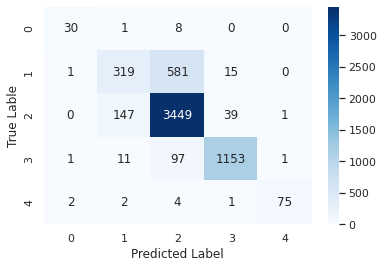

In [86]:
cm = confusion_matrix(np.argmax(yValidation, axis = -1), np.argmax(pred, axis=-1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Lable')
plt.show()

In [88]:
print(classification_report(np.argmax(yValidation, axis = -1), np.argmax(pred, axis=-1)))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82        39
           1       0.66      0.35      0.46       916
           2       0.83      0.95      0.89      3636
           3       0.95      0.91      0.93      1263
           4       0.97      0.89      0.93        84

    accuracy                           0.85      5938
   macro avg       0.86      0.77      0.81      5938
weighted avg       0.84      0.85      0.83      5938

